In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

import syft as sy
hook=sy.TorchHook(torch)

Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/root/anaconda3/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0.so'


### Creating two clients and fitting a linear regression made with a neural network

In [2]:
#torch.rand => uniform distribution

dim=100

X1=torch.rand(dim, 1) 
X2=torch.rand(dim,1)

a_1,b_1=5,-1
a_2,b_2=4,-1.2
y1=a_1*X1+b_1+0.5*torch.randn(dim,1)
y2=a_2*X2+b_2+0.5*torch.randn(dim,1)

### FedAvg for the two clients created above

In [3]:
#Create the server and the clients
server = sy.VirtualWorker(hook, id="server")
C1 = sy.VirtualWorker(hook, id="C1")
C2 = sy.VirtualWorker(hook, id="C2")

#Send the features and the labels to its associated client
C1_x = X1.send(C1)
C1_y = y1.send(C1)

C2_x = X2.send(C2)
C2_y = y2.send(C2)

In [4]:
#metrics we are interested in
C1_loss_hist=[]
C2_loss_hist=[]
S_loss_hist=[]
C1_a_grad=[]
C1_b_grad=[]
C2_a_grad=[]
C2_b_grad=[]

#torch model used for the inference
model = nn.Linear(1,1)

loss_f=nn.MSELoss()
iterations=100
epochs=2
precision=100
epsilon =10**-10
iter_max=1000
i=0

#print(model.weight.data.numpy(),model.bias.data.numpy())

while precision>epsilon and i<iter_max:
    C1_model = model.copy().send(C1)
    C2_model = model.copy().send(C2)
    
    C1_opt = optim.SGD(params=C1_model.parameters(),lr=0.1)
    C2_opt = optim.SGD(params=C2_model.parameters(),lr=0.1)
    
    for j in range(epochs):
        
        # Train Bob's Model
        C1_opt.zero_grad()
        C1_pred = C1_model(C1_x)
        C1_loss = loss_f(C1_pred,C1_y)
        C1_loss.backward()

        C1_opt.step()
        C1_loss = C1_loss.get().data
                
        # Train Alice's Model
        C2_opt.zero_grad()
        C2_pred = C2_model(C2_x)
        C2_loss = loss_f(C2_pred,C2_y)
        C2_loss.backward()

        C2_opt.step()
        C2_loss = C2_loss.get().data
    
    C1_loss_hist+=[C1_loss.numpy()]
    C2_loss_hist+=[C2_loss.numpy()]
    S_loss_hist+=[(C1_loss.numpy()+C2_loss.numpy())/2]
    
    try:precision=(S_loss_hist[-1]-S_loss_hist[-2])**2
    except:pass
    
    C1_model.move(server)
    C2_model.move(server)

    with torch.no_grad():
        
        C1_weight=C1_model.weight.clone().get()
        C2_weight=C2_model.weight.clone().get()
        
        C1_bias=C1_model.bias.clone().get()
        C2_bias=C2_model.bias.clone().get()  
        
        C1_a_grad+=[np.reshape(C1_weight.grad.numpy(),1)]
        C1_b_grad+=[C1_bias.grad.numpy()]
        
        C2_a_grad+=[np.reshape(C2_weight.grad.numpy(),1)]
        C2_b_grad+=[C2_bias.grad.numpy()]        
        
        new_weight=((C1_weight.data + C2_weight.data) / 2)
        new_bias=((C1_bias.data + C2_bias.data) / 2)
        
        model.weight.set_(new_weight)
        model.bias.set_(new_bias)
    
    if i%10==0:
        print("iteration "+str(i))
        print(model.weight.data.numpy(),model.bias.data.numpy())
        print("C1:" + str(C1_loss.detach().numpy()) + " C2:" + str(C2_loss.detach().numpy()))
        print(precision)
    
    i+=1

iteration 0
[[-0.10516887]] [-0.00445468]
C1:5.52048 C2:3.524583
100
iteration 10
[[1.2329364]] [0.61165255]
C1:1.1880093 C2:0.9276107
0.001150545508053824
iteration 20
[[1.8717806]] [0.28427553]
C1:0.89290184 C2:0.6923333
0.0004569543500707596
iteration 30
[[2.3777351]] [0.0217845]
C1:0.7034206 C2:0.5467881
0.00018247148467764873
iteration 40
[[2.7794824]] [-0.18665348]
C1:0.5798712 C2:0.45856652
7.295051182154566e-05
iteration 50
[[3.0984879]] [-0.3521628]
C1:0.49872887 C2:0.40576196
2.920638863557201e-05
iteration 60
[[3.3517928]] [-0.48358464]
C1:0.4449923 C2:0.3747075
1.1713905369248323e-05
iteration 70
[[3.5529284]] [-0.5879396]
C1:0.4090659 C2:0.35690537
4.708755469096104e-06
iteration 80
[[3.7126393]] [-0.67080224]
C1:0.38479006 C2:0.34709275
1.8982263760847218e-06
iteration 90
[[3.839457]] [-0.73659885]
C1:0.36819443 C2:0.34202698
7.67758124631257e-07
iteration 100
[[3.9401565]] [-0.7888446]
C1:0.3567068 C2:0.33972305
3.119505374016285e-07
iteration 110
[[4.0201163]] [-0.83033

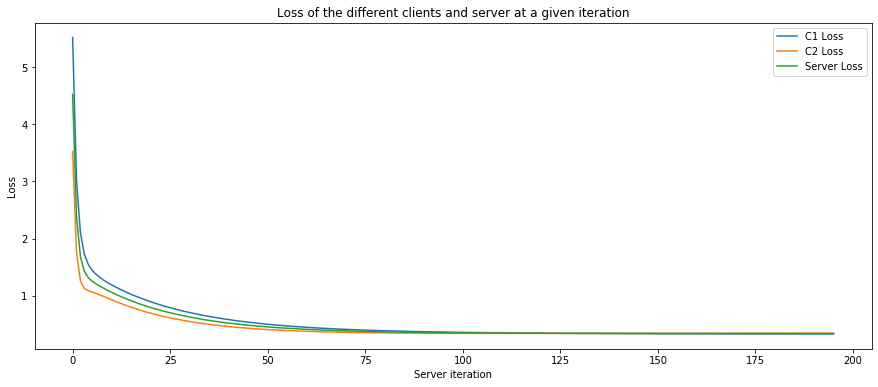

In [5]:
plt.figure(figsize=(15,6))
plt.plot(C1_loss_hist,label="C1 Loss")
plt.plot(C2_loss_hist,label="C2 Loss")
plt.plot(S_loss_hist,label="Server Loss")
plt.title("Loss of the different clients and server at a given iteration")
plt.xlabel("Server iteration")
plt.ylabel("Loss")
plt.legend()

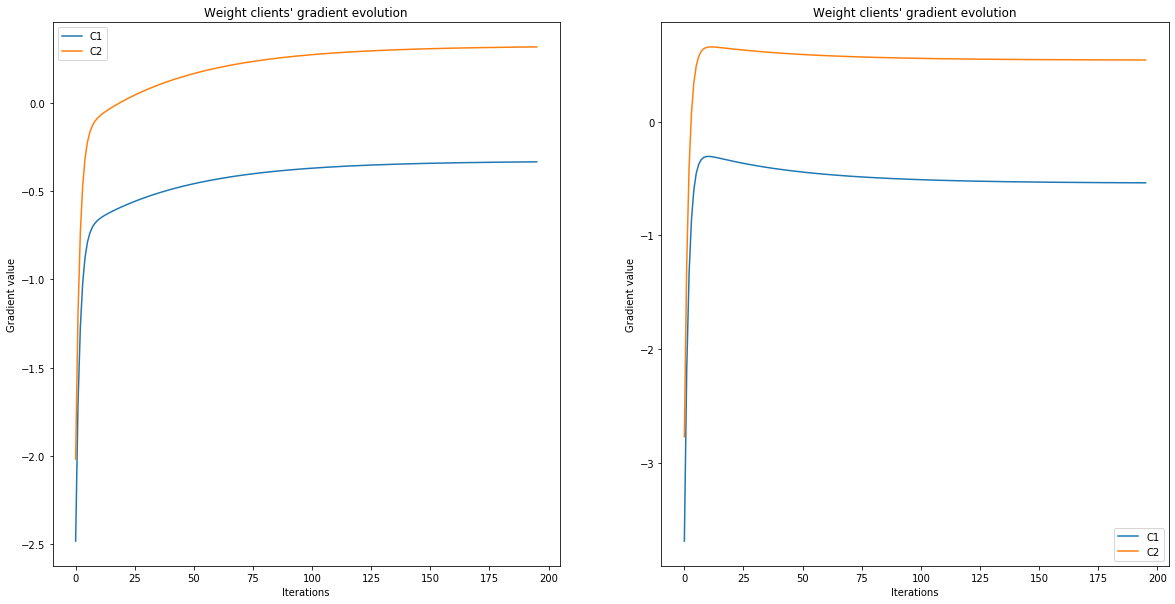

In [6]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(C1_a_grad,label="C1")
plt.plot(C2_a_grad,label="C2")
plt.title("Weight clients' gradient evolution")
plt.xlabel("Iterations")
plt.ylabel("Gradient value")
plt.legend()

plt.subplot(1,2,2)
plt.plot(C1_b_grad,label="C1")
plt.plot(C2_b_grad,label="C2")
plt.title("Weight clients' gradient evolution")
plt.xlabel("Iterations")
plt.ylabel("Gradient value")
plt.legend()

Text(0.5, 0, 'Gradient Bias Client 2')

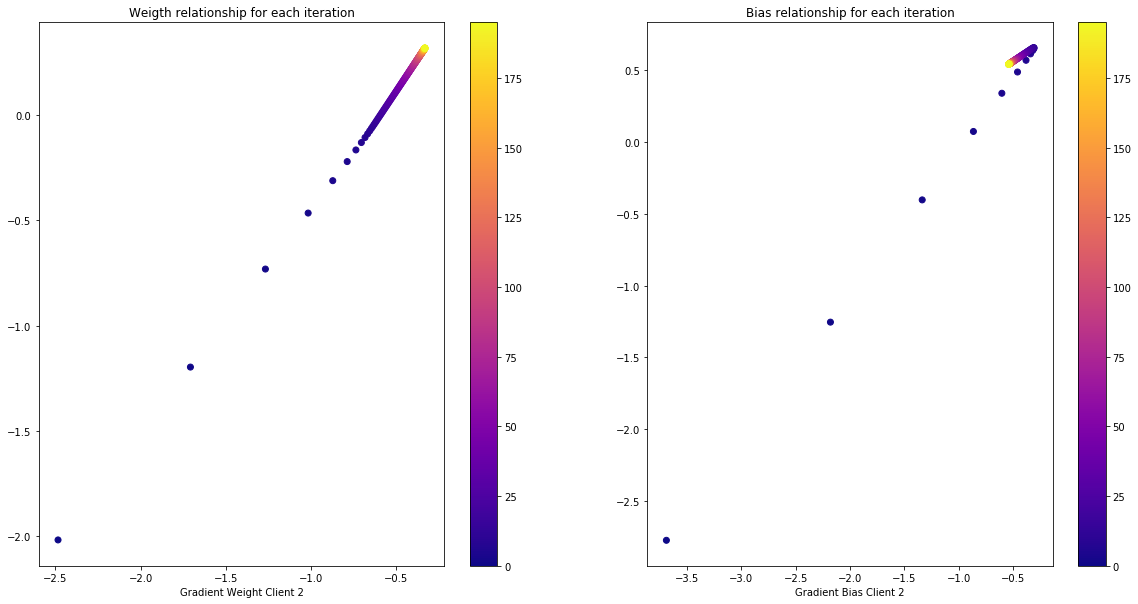

In [7]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.title("Weigth relationship for each iteration")
plt.scatter(C1_a_grad,C2_a_grad,c=[[i] for i in range(len(C1_a_grad))],cmap='plasma')
plt.colorbar()
plt.xlabel("Gradient Weight Client 1")
plt.xlabel("Gradient Weight Client 2")

plt.subplot(1,2,2)
plt.title("Bias relationship for each iteration")
plt.scatter(C1_b_grad,C2_b_grad,c=[[i] for i in range(len(C1_a_grad))],cmap='plasma')
plt.colorbar()
plt.xlabel("Gradient Bias Client 1")
plt.xlabel("Gradient Bias Client 2")